# This file is concerned with creating and training the Transfer learning model

# to execute this file you first run the dataprep file 
# or download the data we prepared by using that file from this link
# https://drive.google.com/drive/folders/1AQU8whF8VYNGBVG_3SWsn3sgqbk7j-4o

# if you download this data you need to place the training and testing folders in the main directory

# Importing Libraries

In [1]:
import os 
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D, MaxPooling2D, BatchNormalization,Dropout, Flatten,Activation,concatenate,Input,AlphaDropout
from tensorflow.keras.optimizers import Adam
from keras import models
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import random as rn
import cv2                  
from tqdm import tqdm
from random import shuffle, randint
import itertools
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16




# Importing Training Dataset

In [2]:
x=[]
y=[]
path='train/'
for ftype in os.listdir(path):
    for img in tqdm(os.listdir(path+ftype)):
        label=ftype
        path1 = os.path.join(path+ftype,img)
        img = cv2.imread(path1)
        x.append(np.array(img))
        y.append(str(label))

100%|██████████| 900/900 [00:11<00:00, 80.85it/s]


# Encoding the data

In [3]:
encoder=LabelEncoder()
y=encoder.fit_transform(y)
y=to_categorical(y,9)
x=np.array(x)

# splitting the data into training and validation datasets using stratified split

In [4]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.10,random_state=42,stratify=y)

In [5]:
np.random.seed(42)
rn.seed(42)

# Visualizing a random image from the training dataset

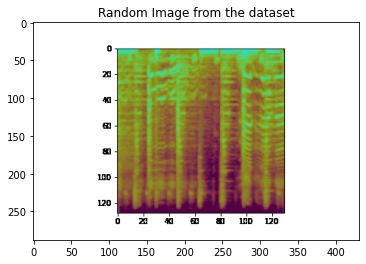

In [6]:
plt.imshow(x_train[randint(0, len(x_train)-1)])
plt.title("Random Image from the dataset")
plt.show()

# Importing VGG 16 as the base model of our neural network

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(288, 432,3))

2022-04-29 18:52:48.770436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:52:48.879560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:52:48.880842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 18:52:48.883064: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 1s 0us/step


# Freezing the weights of the pre-trained base model

In [8]:
for layer in base_model.layers[:]:
    layer.trainable = False

# Adding additional layers to our neural network and creating a new model

In [9]:

model = models.Sequential([
    
   base_model,

   Conv2D(256,kernel_size=(5,5),strides=(1,1)),
   BatchNormalization(axis=-1),
   Activation('relu'),

   Conv2D(128,kernel_size=(3,3),strides=(1,1)),
   BatchNormalization(axis=-1),
   Activation('relu'),

   Conv2D(128,kernel_size=(3,3),strides=(1,1)),
   BatchNormalization(axis=-1),
   Activation('relu'),

   Flatten(),
   Dense(256, activation = "sigmoid"),
   Dense(128, activation = "sigmoid"),
   Dense(9, activation = "softmax")
    
   ])


model.compile(optimizer=Adam(lr=0.0005),loss='CategoricalCrossentropy',metrics=['accuracy'])

# Visializing the model

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 13, 512)        14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 9, 256)         3277056   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 9, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 5, 9, 256)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 7, 128)         295040    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 7, 128)         0

# Training the model for 5 epochs initially

In [11]:
history = model.fit(x_train,y_train, batch_size=128,
                              epochs = 5, 
                              validation_data = (x_val,y_val),
                              verbose = 1,
                             )

2022-04-29 18:52:59.554675: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2721351168 exceeds 10% of free system memory.
2022-04-29 18:53:02.349975: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2721351168 exceeds 10% of free system memory.
2022-04-29 18:53:04.355276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-29 18:53:06.651016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - ETA: 0s - loss: 1.3871 - accuracy: 0.6305

2022-04-29 18:54:16.151059: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 302704128 exceeds 10% of free system memory.
2022-04-29 18:54:16.340204: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 302704128 exceeds 10% of free system memory.


57/57 [==============================] - 83s 1s/step - loss: 1.3871 - accuracy: 0.6305 - val_loss: 1.1291 - val_accuracy: 0.6486
Epoch 2/5
57/57 [==============================] - 37s 645ms/step - loss: 0.5288 - accuracy: 0.8767 - val_loss: 0.6049 - val_accuracy: 0.8052
Epoch 3/5
57/57 [==============================] - 37s 644ms/step - loss: 0.2786 - accuracy: 0.9314 - val_loss: 0.6214 - val_accuracy: 0.7978
Epoch 4/5
57/57 [==============================] - 37s 643ms/step - loss: 0.1747 - accuracy: 0.9612 - val_loss: 0.5382 - val_accuracy: 0.8200
Epoch 5/5
57/57 [==============================] - 37s 643ms/step - loss: 0.1129 - accuracy: 0.9759 - val_loss: 0.4122 - val_accuracy: 0.8755


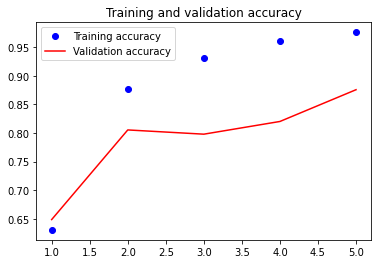

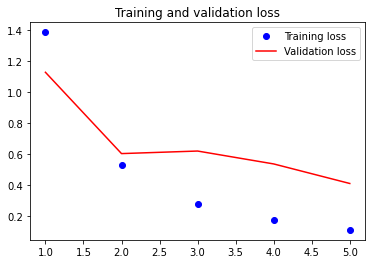

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [13]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


# Unfreezing the last block of layers in the base model

In [14]:
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

In [15]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


# creating callback functions

In [16]:
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.3, min_lr = 0.00001)
checkpoint = ModelCheckpoint('bestmodel.h5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

callbacks = [reduce_learning_rate, checkpoint]

# retraining the model after fine-tuning

In [17]:
model.compile(optimizer=Adam(lr=0.0005),loss='CategoricalCrossentropy',metrics=['accuracy'])

history = model.fit(x_train,y_train, batch_size=128,
                              epochs = 10, 
                              validation_data = (x_val,y_val),
                              callbacks=callbacks,  
                              verbose = 1,
                             )

2022-04-29 18:57:38.948205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2721351168 exceeds 10% of free system memory.


Epoch 1/10
57/57 [==============================] - 43s 725ms/step - loss: 0.5682 - accuracy: 0.8162 - val_loss: 3.8166 - val_accuracy: 0.1467

Epoch 00001: val_accuracy improved from -inf to 0.14673, saving model to bestmodel.h5
Epoch 2/10
57/57 [==============================] - 41s 712ms/step - loss: 0.2549 - accuracy: 0.9192 - val_loss: 0.5752 - val_accuracy: 0.8187

Epoch 00002: val_accuracy improved from 0.14673 to 0.81874, saving model to bestmodel.h5
Epoch 3/10
57/57 [==============================] - 41s 712ms/step - loss: 0.1776 - accuracy: 0.9465 - val_loss: 0.4170 - val_accuracy: 0.8545

Epoch 00003: val_accuracy improved from 0.81874 to 0.85450, saving model to bestmodel.h5
Epoch 4/10
57/57 [==============================] - 41s 715ms/step - loss: 0.1242 - accuracy: 0.9626 - val_loss: 0.9051 - val_accuracy: 0.7226

Epoch 00004: val_accuracy did not improve from 0.85450
Epoch 5/10
57/57 [==============================] - 41s 713ms/step - loss: 0.0865 - accuracy: 0.9754 - va

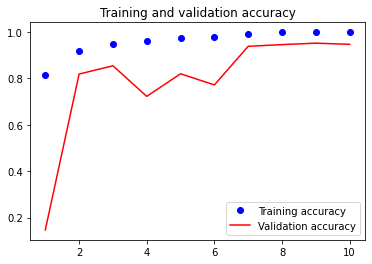

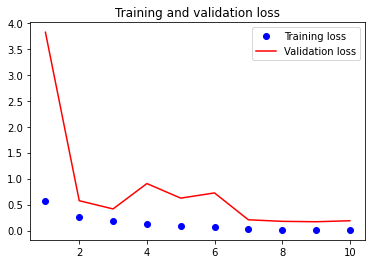

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



# saving the model

In [19]:
model.save('TFmodel.h5')